<a href="https://colab.research.google.com/github/khaanca/UAS_PSM_Kelompok3/blob/main/Fix_UAS_PSM_Kelompok6_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
!pip install optuna
import optuna
import joblib
import os

from IPython import display

# feature engineering + selection
from glob import glob
from librosa import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

# modelling + evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

%matplotlib inline
warnings.filterwarnings('ignore')

  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.16.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.3.0-py3-none-any.whl (386 kB)
Using cached alembic-1.16.1-py3-none-any.whl (242 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [ ]:
# Download the Kaggle API from the Kaggle's account setting, then upload the kaggle.json file here
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# Downloads the kaggle dataset, make sure enter the right dataset name and author
#format: author/name-name2-name3
!kaggle datasets download -d vbookshelf/respiratory-sound-database

!unzip respiratory-sound-database.zip -d respiratory_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database
License(s): unknown
100% 3.67G/3.69G [00:30<00:00, 191MB/s]
100% 3.69G/3.69G [00:30<00:00, 129MB/s]
Archive:  respiratory-sound-database.zip
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Da

In [ ]:
for root, dirs, files in os.walk('respiratory_data'):
    print(f"Folder: {root}")
    for file in files:
        print(f"  - {file}")


Folder: respiratory_data
  - demographic_info.txt
Folder: respiratory_data/Respiratory_Sound_Database
Folder: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database
  - filename_format.txt
  - patient_diagnosis.csv
  - filename_differences.txt
Folder: respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files
  - 156_2b3_Lr_mc_AKGC417L.wav
  - 130_2p5_Tc_mc_AKGC417L.wav
  - 160_1b3_Lr_mc_AKGC417L.wav
  - 186_2b4_Lr_mc_AKGC417L.txt
  - 175_1b1_Pr_sc_Litt3200.wav
  - 155_2b1_Al_mc_LittC2SE.txt
  - 111_1b2_Tc_sc_Meditron.txt
  - 158_1p2_Tc_mc_AKGC417L.wav
  - 205_2b4_Pl_mc_AKGC417L.wav
  - 130_1p3_Lr_mc_AKGC417L.wav
  - 151_3p2_Lr_mc_AKGC417L.txt
  - 197_1b1_Al_sc_Meditron.wav
  - 147_1b3_Tc_mc_AKGC417L.wav
  - 178_2b2_Pr_mc_AKGC417L.wav
  - 178_1b2_Ar_mc_AKGC417L.txt
  - 151_3p2_Pl_mc_AKGC417L.wav
  - 172_1b4_Al_mc_AKGC417L.txt
  - 174_1p2_Lr_mc_AKGC417L.txt
  - 186_2b2_Al_mc_AKGC417L.txt
  - 174_1p3_Ar_mc_AKGC417L.wav
  - 201_1b3_Ar_sc_Med

In [ ]:
base_audio_files = glob('respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/*.wav')
print(f"Found {len(base_audio_files)} files")

all_audio = {}

for audio_file in base_audio_files:
    # extract filename from path
    filename = audio_file.split('\\')[-1] # for Windows paths

    # load audio file
    y, sr = librosa.load(audio_file, mono=True)

    # store in dictionary
    all_audio[filename] = {
        'data': y,
        'sample_rate': sr
    }

print(f'Loaded {len(all_audio)} audio files')

Found 920 files
Loaded 920 audio files


In [ ]:
list(all_audio.keys())[:5]

['respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/156_2b3_Lr_mc_AKGC417L.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/130_2p5_Tc_mc_AKGC417L.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Lr_mc_AKGC417L.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/175_1b1_Pr_sc_Litt3200.wav',
 'respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/158_1p2_Tc_mc_AKGC417L.wav']

# Data Preprocessing

Shortest audio file: respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/124_1b1_Pr_sc_Litt3200.wav
Duration: 7.86 seconds


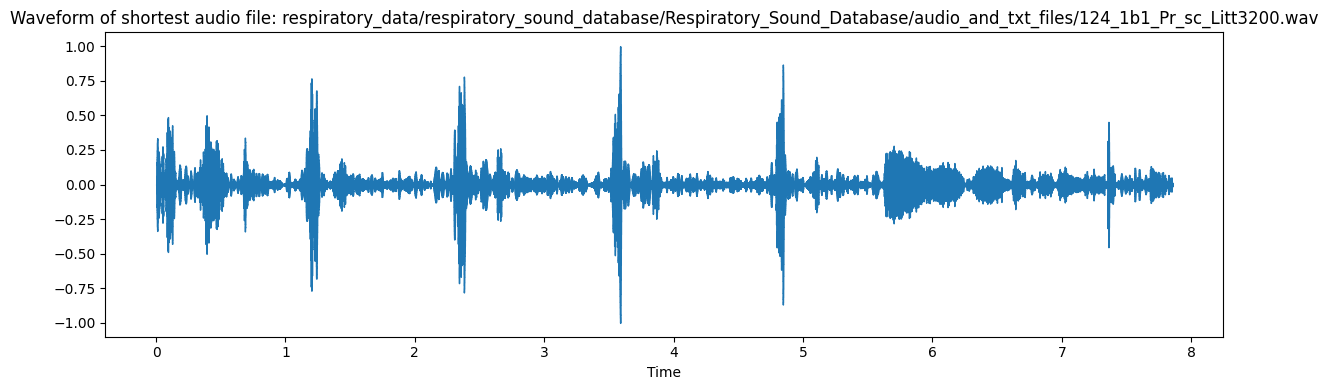

In [ ]:
# calculate duration for each audio file
for filename, audio_info in all_audio.items():
    duration = len(audio_info['data']) / audio_info['sample_rate']
    all_audio[filename]['duration'] = duration

# find the file with the minimum duration
min_duration_file = min(all_audio.items(), key=lambda x: x[1]['duration'])
min_filename = min_duration_file[0]
min_audio_info = min_duration_file[1]

print(f"Shortest audio file: {min_filename}")
print(f"Duration: {min_audio_info['duration']:.2f} seconds")

# plot the waveform of the shortest audio file
plt.figure(figsize=(12, 4))
librosa.display.waveshow(min_audio_info['data'], sr=min_audio_info['sample_rate'])
plt.title(f"Waveform of shortest audio file: {min_filename}")
plt.tight_layout()
plt.show()

display.Audio(data=min_audio_info['data'], rate=min_audio_info['sample_rate'])

In [ ]:
target_duration = min_audio_info['duration']
print(f"Duration of the shortest audio file: {target_duration} seconds")

trimmed_audio = {}

for filename, audio_info in all_audio.items():
    target_samples = int(target_duration * audio_info['sample_rate']) # calculate target samples
    trimmed_data = audio_info['data'][:target_samples] # trimmed to target duration

    # store in dictionary
    trimmed_audio[filename] = {
        'data': trimmed_data,
        'sample_rate': audio_info['sample_rate'],
        'duration': target_duration
    }

print(f'Trimmed all {len(trimmed_audio)} audio files to {target_duration} seconds')

Duration of the shortest audio file: 7.8560090702947845 seconds
Trimmed all 920 audio files to 7.8560090702947845 seconds


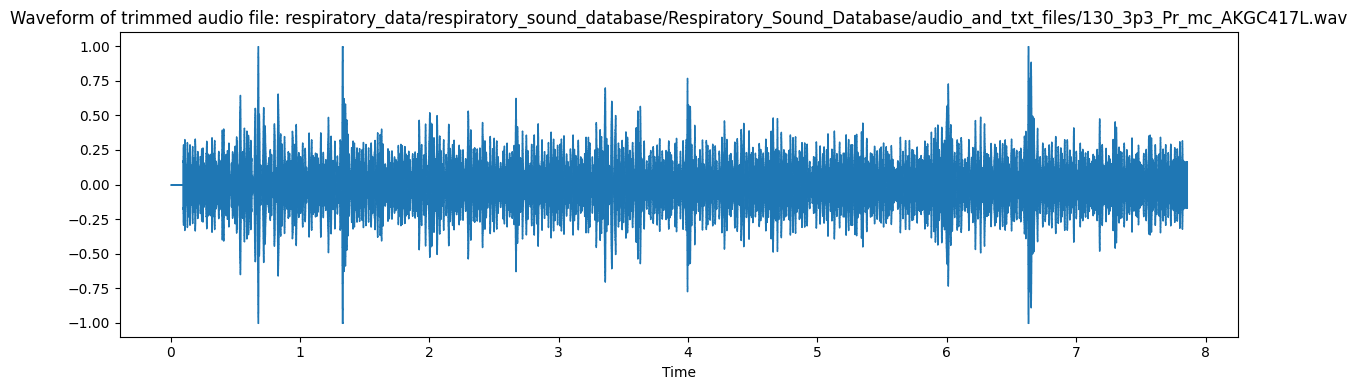

In [ ]:
# plot the waveform of a sample trimmed audio file
sample_file = list(trimmed_audio.keys())[90]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(trimmed_audio[sample_file]['data'], sr=trimmed_audio[sample_file]['sample_rate'])
plt.title(f"Waveform of trimmed audio file: {sample_file}")
plt.tight_layout()
plt.show()

# Feature Extraction

In [ ]:
fn_list = [
    feature.chroma_stft,       # Chromagram from STFT
    feature.mfcc,              # Mel-frequency cepstral coefficients
    feature.melspectrogram,    # Mel-scaled spectrogram
    feature.spectral_contrast, # Spectral contrast
    feature.tonnetz,           # Tonal centroid features
    feature.rms,               # Root-mean-square energy
    feature.zero_crossing_rate,# Zero crossing rate
    feature.spectral_bandwidth,# Spectral bandwidth
    feature.spectral_centroid, # Spectral centroid
    feature.spectral_flatness, # Spectral flatness
    feature.spectral_rolloff,  # Spectral roll-off
    feature.poly_features,     # Polynomial features
    feature.tempogram          # Tempogram
]

audio_features = {}

# extract features for each audio file
for filename, audio_info in trimmed_audio.items():
    y = audio_info['data']
    sr = audio_info['sample_rate']

    audio_features[filename] = {}

    audio_features[filename]['chroma_stft'] = feature.chroma_stft(y=y, sr=sr)
    audio_features[filename]['mfcc'] = feature.mfcc(y=y, sr=sr, n_mfcc=13)
    audio_features[filename]['mel_spectrogram'] = feature.melspectrogram(y=y, sr=sr)
    audio_features[filename]['spectral_contrast'] = feature.spectral_contrast(y=y, sr=sr)
    audio_features[filename]['spectral_centroid'] = feature.spectral_centroid(y=y, sr=sr)
    audio_features[filename]['spectral_bandwidth'] = feature.spectral_bandwidth(y=y, sr=sr)
    audio_features[filename]['spectral_rolloff'] = feature.spectral_rolloff(y=y, sr=sr)
    audio_features[filename]['zero_crossing_rate'] = feature.zero_crossing_rate(y=y)

In [ ]:
# display feature shape for first file
sample_file = list(audio_features.keys())[0]
for feature_name, feature_data in audio_features[sample_file].items():
    print(f"{feature_name}: {feature_data.shape}")

chroma_stft: (12, 339)
mfcc: (13, 339)
mel_spectrogram: (128, 339)
spectral_contrast: (7, 339)
spectral_centroid: (1, 339)
spectral_bandwidth: (1, 339)
spectral_rolloff: (1, 339)
zero_crossing_rate: (1, 339)


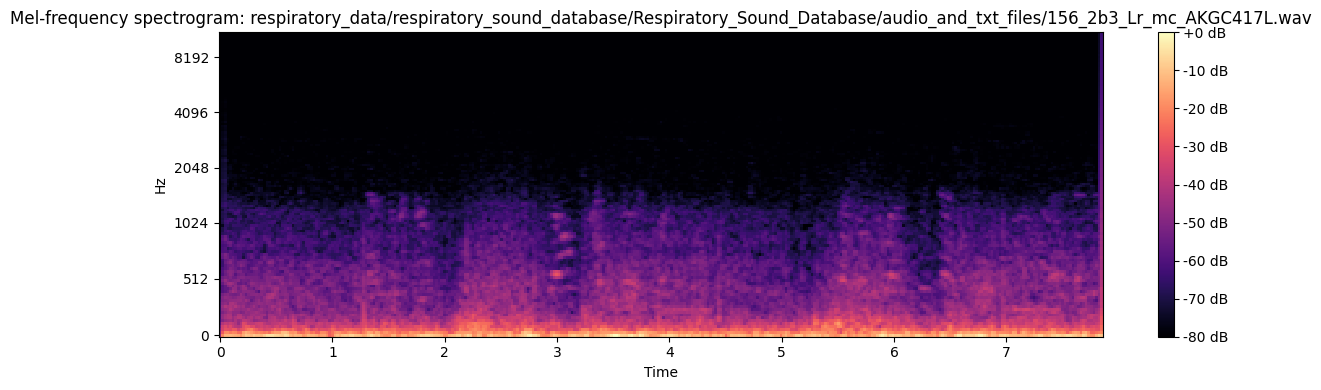

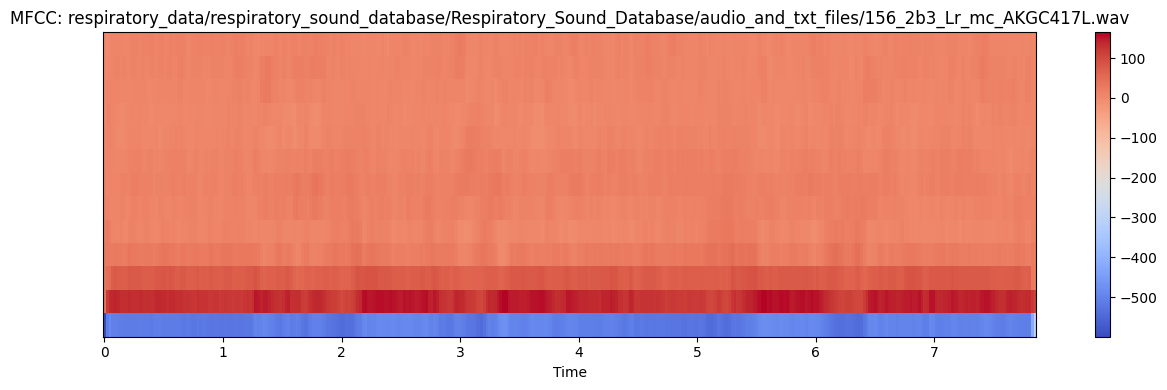

In [ ]:
# sample file to visualize
sample_file = list(audio_features.keys())[0]
sample_data = trimmed_audio[sample_file]['data']
sample_sr = trimmed_audio[sample_file]['sample_rate']

# plot mel spectrogram
plt.figure(figsize=(12, 4))
S = librosa.feature.melspectrogram(y=sample_data, sr=sample_sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram: {sample_file}')
plt.tight_layout()
plt.show()

# plot mfccs
plt.figure(figsize=(12, 4))
mfccs = librosa.feature.mfcc(y=sample_data, sr=sample_sr, n_mfcc=13)
librosa.display.specshow(mfccs, x_axis='time', sr=sample_sr)
plt.colorbar()
plt.title(f'MFCC: {sample_file}')
plt.tight_layout()
plt.show()

In [ ]:
feature_stats = []

for filename, features in audio_features.items():
    file_stats = {'filename': filename}

    # calculate statistics for each feature
    for feature_name, feature_data in features.items():
        file_stats[f'{feature_name}_mean'] = np.mean(feature_data)
        file_stats[f'{feature_name}_std'] = np.std(feature_data)
        file_stats[f'{feature_name}_max'] = np.max(feature_data)
        file_stats[f'{feature_name}_min'] = np.min(feature_data)

    feature_stats.append(file_stats)

# create dataframe
df = pd.DataFrame(feature_stats)
df.head()

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_max,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min
0,respiratory_data/respiratory_sound_database/Re...,0.781793,0.175163,1.0,0.104412,-12.258308,147.961014,164.816193,-599.583740,0.259175,...,2557.878978,601.912560,213.871076,238.328712,3682.177734,43.066406,0.004766,0.014191,0.149902,0.000488
1,respiratory_data/respiratory_sound_database/Re...,0.727037,0.184041,1.0,0.000000,-5.944583,89.550690,105.567139,-627.879272,0.352735,...,3608.310757,0.000000,4517.462752,1455.170870,10766.601562,0.000000,0.017970,0.016555,0.097168,0.000000
2,respiratory_data/respiratory_sound_database/Re...,0.758462,0.194323,1.0,0.000000,3.195275,112.353218,210.993774,-458.365143,21.524797,...,2491.253663,0.000000,160.228628,639.801610,10766.601562,0.000000,0.003693,0.008996,0.085449,0.000000
3,respiratory_data/respiratory_sound_database/Re...,0.667071,0.259139,1.0,0.011003,-6.058329,132.870239,195.412048,-506.060303,2.081561,...,1783.015334,56.167564,174.679376,125.533144,581.396484,32.299805,0.005145,0.003219,0.016602,0.000488
4,respiratory_data/respiratory_sound_database/Re...,0.716688,0.218416,1.0,0.000000,-0.082429,105.542969,207.667175,-478.825867,7.945040,...,2009.761983,0.000000,432.188537,596.343007,10766.601562,0.000000,0.006762,0.010353,0.098145,0.000000


In [ ]:
# read patient diagnosis data
patient_diagnosis = pd.read_csv('respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', header=None)
patient_diagnosis.columns = ['patient_id', 'diagnosis']

patient_diagnosis.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
df['filename'] = df['filename'].str.replace('respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/', '', regex=False)

df.head()

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_max,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min
0,156_2b3_Lr_mc_AKGC417L.wav,0.781793,0.175163,1.0,0.104412,-12.258308,147.961014,164.816193,-599.583740,0.259175,...,2557.878978,601.912560,213.871076,238.328712,3682.177734,43.066406,0.004766,0.014191,0.149902,0.000488
1,130_2p5_Tc_mc_AKGC417L.wav,0.727037,0.184041,1.0,0.000000,-5.944583,89.550690,105.567139,-627.879272,0.352735,...,3608.310757,0.000000,4517.462752,1455.170870,10766.601562,0.000000,0.017970,0.016555,0.097168,0.000000
2,160_1b3_Lr_mc_AKGC417L.wav,0.758462,0.194323,1.0,0.000000,3.195275,112.353218,210.993774,-458.365143,21.524797,...,2491.253663,0.000000,160.228628,639.801610,10766.601562,0.000000,0.003693,0.008996,0.085449,0.000000
3,175_1b1_Pr_sc_Litt3200.wav,0.667071,0.259139,1.0,0.011003,-6.058329,132.870239,195.412048,-506.060303,2.081561,...,1783.015334,56.167564,174.679376,125.533144,581.396484,32.299805,0.005145,0.003219,0.016602,0.000488
4,158_1p2_Tc_mc_AKGC417L.wav,0.716688,0.218416,1.0,0.000000,-0.082429,105.542969,207.667175,-478.825867,7.945040,...,2009.761983,0.000000,432.188537,596.343007,10766.601562,0.000000,0.006762,0.010353,0.098145,0.000000


In [ ]:
# map the diagnosis to the dataframe based on the patient ID extracted from the filename
df['diagnosis'] = df['filename'].apply(
	lambda x: patient_diagnosis.loc[
		patient_diagnosis['patient_id'] == int(x.split('_')[0]), 'diagnosis'
	].values[0] if int(x.split('_')[0]) in patient_diagnosis['patient_id'].values else None
)

df

,filename,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,mfcc_mean,mfcc_std,mfcc_max,mfcc_min,mel_spectrogram_mean,...,spectral_bandwidth_min,spectral_rolloff_mean,spectral_rolloff_std,spectral_rolloff_max,spectral_rolloff_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_max,zero_crossing_rate_min,diagnosis
0,156_2b3_Lr_mc_AKGC417L.wav,0.781793,0.175163,1.0,0.104412,-12.258308,147.961014,164.816193,-599.583740,0.259175,...,601.912560,213.871076,238.328712,3682.177734,43.066406,0.004766,0.014191,0.149902,0.000488,COPD
1,130_2p5_Tc_mc_AKGC417L.wav,0.727037,0.184041,1.0,0.000000,-5.944583,89.550690,105.567139,-627.879272,0.352735,...,0.000000,4517.462752,1455.170870,10766.601562,0.000000,0.017970,0.016555,0.097168,0.000000,COPD
2,160_1b3_Lr_mc_AKGC417L.wav,0.758462,0.194323,1.0,0.000000,3.195275,112.353218,210.993774,-458.365143,21.524797,...,0.000000,160.228628,639.801610,10766.601562,0.000000,0.003693,0.008996,0.085449,0.000000,COPD
3,175_1b1_Pr_sc_Litt3200.wav,0.667071,0.259139,1.0,0.011003,-6.058329,132.870239,195.412048,-506.060303,2.081561,...,56.167564,174.679376,125.533144,581.396484,32.299805,0.005145,0.003219,0.016602,0.000488,COPD
4,158_1p2_Tc_mc_AKGC417L.wav,0.716688,0.218416,1.0,0.000000,-0.082429,105.542969,207.667175,-478.825867,7.945040,...,0.000000,432.188537,596.343007,10766.601562,0.000000,0.006762,0.010353,0.098145,0.000000,COPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,193_1b2_Ll_mc_AKGC417L.wav,0.422508,0.202484,1.0,0.000000,-6.109918,92.961716,107.502518,-744.949524,0.255792,...,0.000000,4294.127230,827.753041,10766.601562,0.000000,0.016858,0.009591,0.094727,0.000000,COPD
916,130_2p5_Al_mc_AKGC417L.wav,0.748624,0.201771,1.0,0.000000,7.031874,93.547836,199.189667,-432.289154,45.293896,...,0.000000,321.092454,785.441920,10766.601562,0.000000,0.005138,0.010644,0.093750,0.000000,COPD
917,107_2b4_Ll_mc_AKGC417L.wav,0.728440,0.213396,1.0,0.000000,2.147513,90.159302,157.124496,-504.471039,5.655554,...,0.000000,1023.144747,1087.314603,10766.601562,0.000000,0.010068,0.012428,0.119141,0.000000,COPD
918,138_2p2_Pr_mc_AKGC417L.wav,0.702660,0.230892,1.0,0.000000,4.764368,86.281616,189.107452,-436.322845,13.166524,...,0.000000,816.451405,1047.831214,10755.834961,0.000000,0.008936,0.012191,0.110352,0.000000,COPD


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 920 non-null    object 
 1   chroma_stft_mean         920 non-null    float32
 2   chroma_stft_std          920 non-null    float32
 3   chroma_stft_max          920 non-null    float32
 4   chroma_stft_min          920 non-null    float32
 5   mfcc_mean                920 non-null    float32
 6   mfcc_std                 920 non-null    float32
 7   mfcc_max                 920 non-null    float32
 8   mfcc_min                 920 non-null    float32
 9   mel_spectrogram_mean     920 non-null    float32
 10  mel_spectrogram_std      920 non-null    float32
 11  mel_spectrogram_max      920 non-null    float32
 12  mel_spectrogram_min      920 non-null    float32
 13  spectral_contrast_mean   920 non-null    float64
 14  spectral_contrast_std    9

In [ ]:
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicated rows: {df.duplicated().sum()}")

Missing values: 0
Duplicated rows: 0


# Exploratory Data Analysis

Target value counts: diagnosis
3    793
6     37
4     35
7     23
1     16
2     13
5      2
0      1
Name: count, dtype: int64


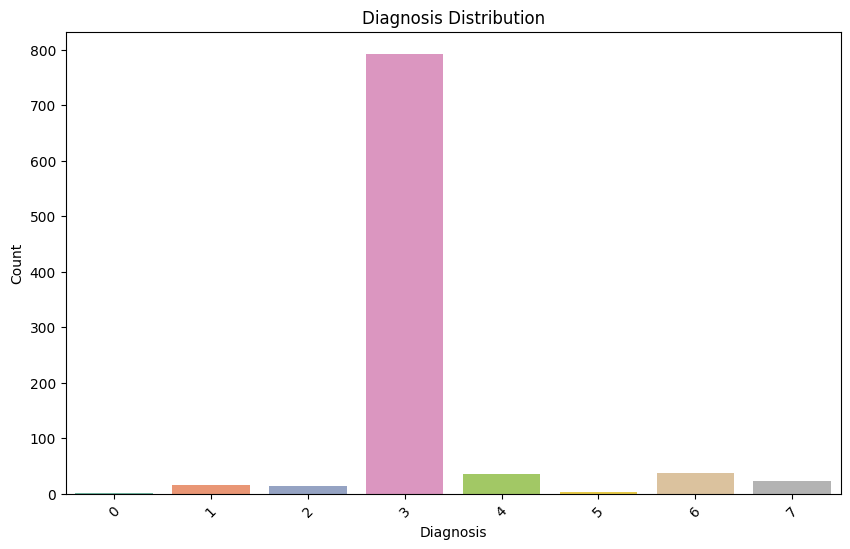

In [ ]:
df_2 = df.copy()

le = LabelEncoder()

df_2['diagnosis'] = le.fit_transform(df_2['diagnosis'])

print(f"Target value counts: {df_2['diagnosis'].value_counts()}")

# plot target proportion using bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_2, x='diagnosis', palette='Set2')
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

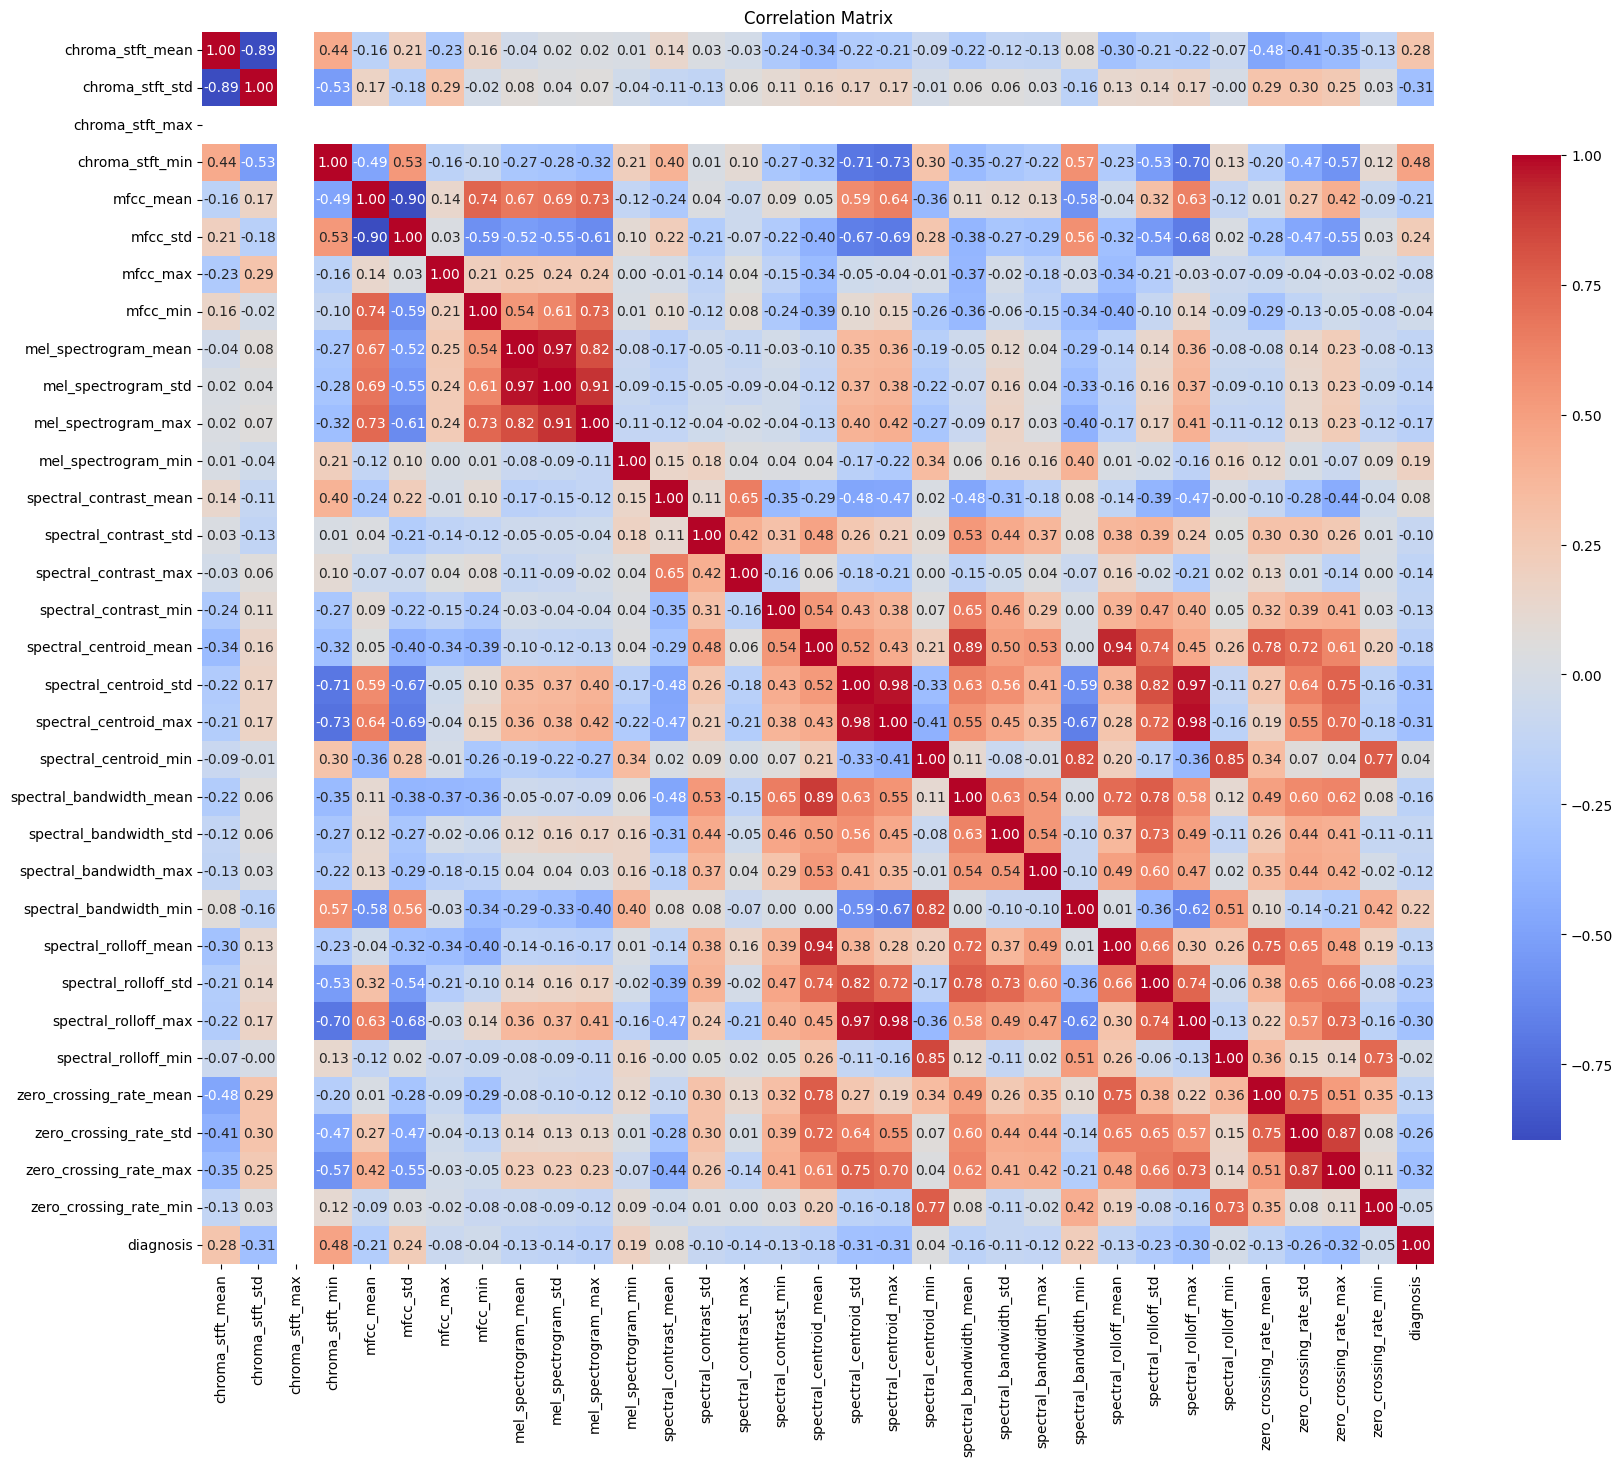

In [ ]:
df_2 = df_2.drop(['filename'], axis=1)

corr_mat = df_2.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

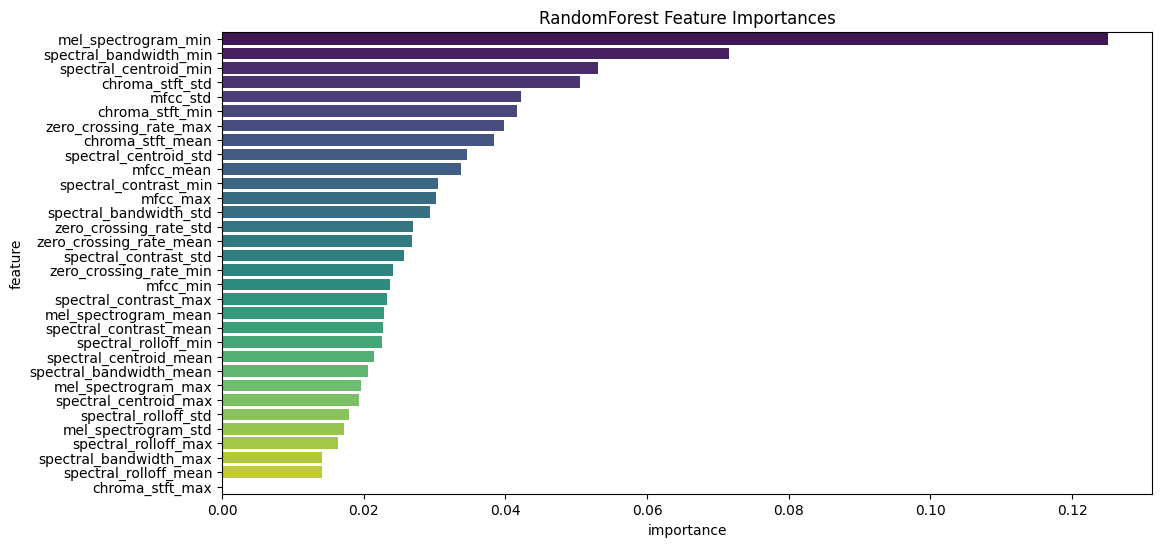

In [ ]:
X = df.select_dtypes(exclude=['object'])
y = df['diagnosis'].values

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('RandomForest Feature Importances')
plt.show()

In [ ]:
excluded_features = ['mel_spectrogram_min', 'chroma_stft_max']

X = X.drop(excluded_features, axis=1)

X.columns

Index(['chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_min', 'mfcc_mean',
       'mfcc_std', 'mfcc_max', 'mfcc_min', 'mel_spectrogram_mean',
       'mel_spectrogram_std', 'mel_spectrogram_max', 'spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_contrast_max',
       'spectral_contrast_min', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_centroid_max',
       'spectral_centroid_min', 'spectral_bandwidth_mean',
       'spectral_bandwidth_std', 'spectral_bandwidth_max',
       'spectral_bandwidth_min', 'spectral_rolloff_mean',
       'spectral_rolloff_std', 'spectral_rolloff_max', 'spectral_rolloff_min',
       'zero_crossing_rate_mean', 'zero_crossing_rate_std',
       'zero_crossing_rate_max', 'zero_crossing_rate_min'],
      dtype='object')

In [ ]:
pd.Series(y).value_counts()

,count
COPD,793
Pneumonia,37
Healthy,35
URTI,23
Bronchiectasis,16
Bronchiolitis,13
LRTI,2
Asthma,1


# Modelling and Evaluation

[I 2025-06-08 12:50:18,351] A new study created in memory with name: no-name-da8269a8-da6c-4c0f-8e86-15af032473bb


Starting hyperparameter optimization...


[I 2025-06-08 12:50:19,339] Trial 0 finished with value: 0.8866936362645744 and parameters: {'n_estimators': 153, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8866936362645744.
[I 2025-06-08 12:50:20,734] Trial 1 finished with value: 0.907548972766364 and parameters: {'n_estimators': 224, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.907548972766364.
[I 2025-06-08 12:50:22,382] Trial 2 finished with value: 0.898520277676288 and parameters: {'n_estimators': 143, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.907548972766364.
[I 2025-06-08 12:50:23,355] Trial 3 finished with value: 0.8865458390714146 and parameters: {'n_estimators': 225, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.907548972766364.



Best F1 Score: 0.9455
Best hyperparameters:
    n_estimators: 96
    max_depth: 42
    min_samples_split: 10
    min_samples_leaf: 1
    max_features: None

Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00         3
 Bronchiolitis       0.00      0.00      0.00         1
          COPD       1.00      0.98      0.99        81
       Healthy       0.00      0.00      0.00         2
     Pneumonia       0.80      0.80      0.80         5
          URTI       0.00      0.00      0.00         0

      accuracy                           0.93        92
     macro avg       0.47      0.46      0.46        92
  weighted avg       0.96      0.93      0.95        92

F1 Score: 0.9455
Accuracy: 0.9348


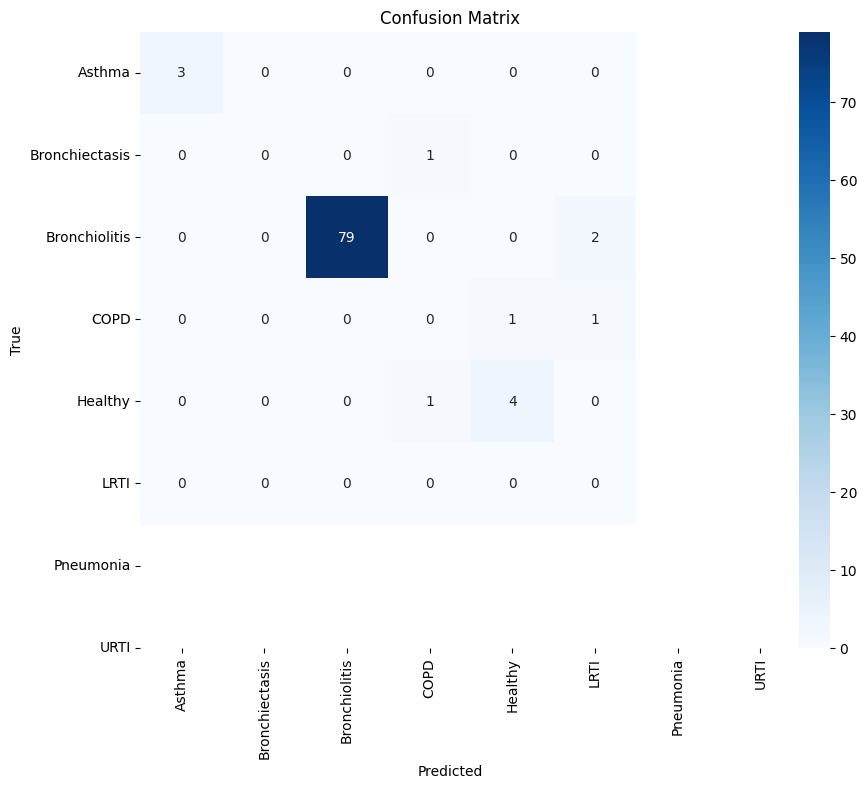

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)

X_vali, X_test, y_vali, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=15)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))

# Hyperparameter optimization
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }

    rf = RandomForestClassifier(**params, random_state=42, class_weight=class_weights_dict, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

# Run optimization
print("Starting hyperparameter optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print(f"\nBest F1 Score: {study.best_value:.4f}")
print("Best hyperparameters:")
for param, value in best_params.items():
    print(f"    {param}: {value}")

# Train final model
rf_optimized = RandomForestClassifier(**best_params, random_state=42, class_weight=class_weights_dict, n_jobs=-1)
rf_optimized.fit(X_train, y_train)
y_pred = rf_optimized.predict(X_test)

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# custom transformer to load audio files
class AudioLoader(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Load audio files from a list of file paths"""
        result = {}
        for file_path in X:
            filename = file_path.split('\\')[-1] if '\\' in file_path else file_path.split('/')[-1]
            y, sr = librosa.load(file_path, mono=True)
            result[filename] = {'data': y, 'sample_rate': sr}
        return result

# custom transformer to trim audio to consistent duration
class AudioTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, target_duration=7.8560090702947845):  # default duration in seconds
        self.target_duration = target_duration

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Trim audio files to consistent duration"""
        trimmed = {}
        for filename, audio_info in X.items():
            target_samples = int(self.target_duration * audio_info['sample_rate'])

            # if audio is shorter than target, pad with zeros
            if len(audio_info['data']) < target_samples:
                trimmed_data = np.pad(audio_info['data'],
                                     (0, target_samples - len(audio_info['data'])),
                                     'constant')
            else:
                trimmed_data = audio_info['data'][:target_samples]

            trimmed[filename] = {
                'data': trimmed_data,
                'sample_rate': audio_info['sample_rate'],
                'duration': self.target_duration
            }
        return trimmed

# custom transformer to extract audio features
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Extract audio features"""
        features = {}
        for filename, audio_info in X.items():
            y_audio = audio_info['data']
            sr = audio_info['sample_rate']

            features[filename] = {}
            features[filename]['chroma_stft'] = librosa.feature.chroma_stft(y=y_audio, sr=sr)
            features[filename]['mfcc'] = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
            features[filename]['mel_spectrogram'] = librosa.feature.melspectrogram(y=y_audio, sr=sr)
            features[filename]['spectral_contrast'] = librosa.feature.spectral_contrast(y=y_audio, sr=sr)
            features[filename]['spectral_centroid'] = librosa.feature.spectral_centroid(y=y_audio, sr=sr)
            features[filename]['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y_audio, sr=sr)
            features[filename]['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=y_audio, sr=sr)
            features[filename]['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y=y_audio)

        return features

# custom transformer to calculate feature statistics
class FeatureStatisticsCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, excluded_features=None):
        self.excluded_features = excluded_features or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Calculate statistics for each feature"""
        feature_stats = []
        for filename, features in X.items():
            file_stats = {'filename': filename}

            for feature_name, feature_data in features.items():
                file_stats[f'{feature_name}_mean'] = np.mean(feature_data)
                file_stats[f'{feature_name}_std'] = np.std(feature_data)
                file_stats[f'{feature_name}_max'] = np.max(feature_data)
                file_stats[f'{feature_name}_min'] = np.min(feature_data)

            feature_stats.append(file_stats)

        # create dataframe
        df = pd.DataFrame(feature_stats)

        # exclude features if specified
        for feature in self.excluded_features:
            if feature in df.columns:
                df = df.drop(feature, axis=1)

        # keep only numeric columns for prediction
        return df.select_dtypes(exclude=['object'])

# save the trained Random Forest model
def save_model(model, filename='respiratory_classifier.pkl'):
    """Save the trained model"""
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# function to create and save respiratory classification pipeline
def create_respiratory_pipeline():
    """Create a pipeline for respiratory sound classification"""
    # define excluded features based on previous analysis
    excluded_features = ['mel_spectrogram_min', 'chroma_stft_max']

    # build the preprocessing pipeline only
    preprocessing_pipeline = Pipeline([
        ('load_audio', AudioLoader()),
        ('trim_audio', AudioTrimmer(target_duration=7.8560090702947845)),  # Use a standard duration
        ('extract_features', FeatureExtractor()),
        ('calculate_statistics', FeatureStatisticsCalculator(excluded_features=excluded_features))
    ])

    return preprocessing_pipeline

# function to predict respiratory condition using the saved model
def predict_respiratory_condition(wav_file_path, model_path='respiratory_classifier.pkl'):
    """Predict respiratory condition from a WAV file using a saved model"""
    # load the saved model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found")

    model = joblib.load(model_path)

    # create preprocessing pipeline
    preprocessing_pipeline = create_respiratory_pipeline()

    # process the audio file
    features_df = preprocessing_pipeline.transform([wav_file_path])

    # make prediction
    prediction = model.predict(features_df)[0]
    probabilities = model.predict_proba(features_df)[0]

    # get the class with highest probability and its probability value
    max_prob = np.max(probabilities)
    classes = model.classes_

    return {
        'prediction': prediction,
        'probability': max_prob,
        'all_probabilities': dict(zip(classes, probabilities))
    }

save_model(rf_optimized)

from google.colab import files
files.download("respiratory_classifier.pkl")

Model saved as respiratory_classifier.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(X_vali)
print(y_vali)


     chroma_stft_mean  chroma_stft_std  chroma_stft_min  mfcc_mean  \
647          0.758539         0.203822         0.000000  -0.898734   
175          0.791954         0.164065         0.198600 -14.312397   
906          0.790944         0.166156         0.263369 -13.281399   
891          0.782959         0.180913         0.000000   4.987198   
211          0.796153         0.169037         0.205550  -8.575224   
..                ...              ...              ...        ...   
634          0.727627         0.201563         0.128728 -24.670259   
514          0.793228         0.167466         0.252863  -8.984399   
262          0.794019         0.175795         0.000000  -2.479030   
736          0.763803         0.181631         0.163695  -7.500418   
711          0.777250         0.181782         0.000000  -2.943495   

       mfcc_std    mfcc_max    mfcc_min  mel_spectrogram_mean  \
647   90.156517  155.336945 -482.844330              5.166703   
175  154.147232  193.400681 -

# Testing

In [ ]:
df[['filename','diagnosis']].sample()

,filename,diagnosis
341,157_1b1_Ar_sc_Meditron.wav,COPD


In [ ]:
# pipeline usage
result = predict_respiratory_condition('respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/152_1b1_Al_sc_Meditron.wav',
                                       model_path='respiratory_classifier.pkl')
print(f"Predicted condition: {result['prediction']} (confidence: {result['probability']:.2f})")

Predicted condition: Healthy (confidence: 0.55)
